# Eindopdracht 2: Machine Translation & Document Search

Naam: Sietse Neve

Studentnummer: 1810364

# Naïeve Machine Translation (EN → FR) met Vector Embeddings

Dit notebook bouwt een *simpel maar compleet* woord-naar-woord-vertalsysteem:
- We leren een **lineaire mapping** \(R\) tussen Engelse en Franse embed-ruimtes
  door de **Frobenius-norm**-loss te minimaliseren met **gradient descent**:
  
  \[
  L(R) = \frac{1}{m}\lVert X R - Y \rVert_F^2
  \quad\Rightarrow\quad
  \nabla_R L = \frac{2}{m} X^\top (X R - Y)
  \]
  
- Nieuwe woorden vertalen we door:
  1) embedding opzoeken (EN)  
  2) projecteren met \(R\) naar FR-ruimte  
  3) **k-nearest neighbors** zoeken o.b.v. **cosine similarity** in FR-ruimte

Met de settings uit de opdracht (400 stappen, lr=0.8) kun je doorgaans >55% top-1 accuracy halen op de testset.

**Bestanden die je nodig hebt** (zoals in de opdracht):
- `en_embeddings.p` — Engelse embeddings (subset)
- `fr_embeddings.p` — Franse embeddings (subset)
- `en_fr.train.txt` — train-woordparen (EN FR)
- `en_fr.test.txt` — test-woordparen (EN FR)

We houden de code modulair en rijk becommentarieerd, vergelijkbaar met de stijl van je eerdere uitwerking — maar alles hier is fris geschreven voor deze opdracht.


In [1]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Iterable, List, Sequence, Tuple

import numpy as np
import pickle
import os


In [2]:
def load_embeddings(path: str) -> Dict[str, np.ndarray]:
    """
    Laadt een pickled dict: { "woord": np.ndarray(d,), ... }.
    - Converteert waarden naar float32 voor snelheid/zuinig geheugen.
    - Geen ordeningsaanname; voor k-NN bouwen we later een matrix.

    Waarom pickle?
    - Snel en direct voor Python dicts met numpy arrays (zoals deze cursusbestanden).
    """
    with open(path, "rb") as f:
        data = pickle.load(f)
    for k, v in list(data.items()):
        data[k] = np.asarray(v, dtype=np.float32).reshape(-1)
    return data


def load_pairs(path: str) -> List[Tuple[str, str]]:
    """
    Leest (en, fr)-paren uit een 2-koloms textbestand met spatie-separatie.
    Lege regels worden overgeslagen.
    """
    pairs = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            en, fr = line.split()
            pairs.append((en, fr))
    return pairs


In [3]:
def build_alignment_matrices(
    pairs: Sequence[Tuple[str, str]],
    en_embeddings: Dict[str, np.ndarray],
    fr_embeddings: Dict[str, np.ndarray],
) -> Tuple[np.ndarray, np.ndarray, List[Tuple[str, str]]]:
    """
    Maakt X (EN) en Y (FR) door voor elk (en, fr)-paar de bijbehorende embeddings te stapelen.
    - Pairs met ontbrekende embeddings worden gefilterd (zoals gebruikelijk in de opdracht).
    - Controleert bovendien de embed-dimensies (moeten gelijk zijn aan beide kanten).

    Returns:
        X: (m, d), Y: (m, d), kept_pairs: de effectief gebruikte paren
    """
    X_rows, Y_rows, kept = [], [], []
    for en, fr in pairs:
        v_en = en_embeddings.get(en)
        v_fr = fr_embeddings.get(fr)
        if v_en is None or v_fr is None:
            continue
        v_en = np.asarray(v_en, dtype=np.float32).reshape(-1)
        v_fr = np.asarray(v_fr, dtype=np.float32).reshape(-1)
        if v_en.shape != v_fr.shape:
            # Embedding-dimensie mismatch; skip dit paar om bugs te voorkomen
            continue
        X_rows.append(v_en)
        Y_rows.append(v_fr)
        kept.append((en, fr))

    if not X_rows:
        raise ValueError("Geen bruikbare trainingpairs over. Controleer je bestanden/paths.")
    X = np.vstack(X_rows).astype(np.float32)
    Y = np.vstack(Y_rows).astype(np.float32)
    return X, Y, kept


In [4]:
@dataclass
class GDConfig:
    """
    Config voor full-batch gradient descent.
    - num_iters & learning_rate volgen de opdracht.
    - l2_reg is optioneel (default 0.0 om aan te sluiten bij de basisopdracht).
    - init kan "zeros" (zoals vaak in colleges) of "eye" (kan soms sneller convergeren).
    """
    num_iters: int = 400
    learning_rate: float = 0.8
    l2_reg: float = 0.0
    init: str = "zeros"  # of "eye"


def _loss_and_grad(X: np.ndarray, Y: np.ndarray, R: np.ndarray, l2_reg: float = 0.0) -> Tuple[float, np.ndarray]:
    """
    Berekent:
        L(R) = (1/m)||XR - Y||_F^2 + λ||R||_F^2
    en de gradiënt:
        ∇_R L = (2/m) Xᵀ (X R - Y) + 2λR

    Waarom Frobenius?
    - Dit is precies de som van kwadraten over alle elementen; elegant en efficiënt te differentiëren.
    """
    m = X.shape[0]
    XR_minus_Y = X @ R - Y
    data_loss = (XR_minus_Y ** 2).sum() / m
    reg_loss = l2_reg * (R ** 2).sum()
    loss = float(data_loss + reg_loss)

    grad = (2.0 / m) * (X.T @ XR_minus_Y)
    if l2_reg:
        grad = grad + 2.0 * l2_reg * R
    return loss, grad


In [5]:
def fit_linear_map(
    X: np.ndarray,
    Y: np.ndarray,
    cfg: GDConfig = GDConfig(),
    verbose: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    """
    Leert R (d×d) met full-batch GD op de Frobenius-loss.
    - Duidelijke logging per ~10% van het aantal iteraties.
    - Retourneert R en de loss-geschiedenis (voor diagnose/plots).
    """
    m, d = X.shape
    if Y.shape != (m, d):
        raise ValueError(f"Shape mismatch: X{X.shape} vs Y{Y.shape}")

    if cfg.init == "zeros":
        R = np.zeros((d, d), dtype=np.float32)
    elif cfg.init == "eye":
        R = np.eye(d, dtype=np.float32)
    else:
        raise ValueError("cfg.init moet 'zeros' of 'eye' zijn.")

    losses = []
    for it in range(1, cfg.num_iters + 1):
        loss, grad = _loss_and_grad(X, Y, R, l2_reg=cfg.l2_reg)
        R = R - cfg.learning_rate * grad
        losses.append(loss)

        if verbose and (it == 1 or it % max(1, cfg.num_iters // 10) == 0 or it == cfg.num_iters):
            print(f"[GD] iter {it:4d}/{cfg.num_iters} | loss = {loss:.6f}")
    return R, losses


In [6]:
def _l2_normalize_rows(M: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """
    L2-normaliseert elke rij afzonderlijk. Dit maakt cosine-similarity sneller/robuuster.
    """
    norms = np.linalg.norm(M, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return M / norms


def build_french_matrix(fr_embeddings: Dict[str, np.ndarray], l2_normalize: bool = True) -> Tuple[np.ndarray, List[str]]:
    """
    Pakt FR-embeddings in een (n_fr, d)-matrix + een woordenlijst in dezelfde volgorde.
    (Optioneel) normaliseert de rijen één keer vooraf (performant).
    """
    fr_words = list(fr_embeddings.keys())
    if not fr_words:
        raise ValueError("Franse embedding-dict is leeg.")

    d = fr_embeddings[fr_words[0]].shape[0]
    F = np.vstack([fr_embeddings[w].reshape(1, -1) for w in fr_words]).astype(np.float32)
    if l2_normalize:
        F = _l2_normalize_rows(F)
    return F, fr_words


def _cosine_scores(vec: np.ndarray, M_unitrows: np.ndarray) -> np.ndarray:
    """
    Cosine-similarity tussen een *enkele* vector en alle rijen van M.
    Aannames:
    - Rijen van M zijn al L2-genormaliseerd.
    - We normaliseren `vec` ook één keer.
    """
    v = vec.astype(np.float32).reshape(1, -1)
    v = _l2_normalize_rows(v)
    return (v @ M_unitrows.T).ravel()


def translate(
    english_word: str,
    R: np.ndarray,
    en_embeddings: Dict[str, np.ndarray],
    F_unitrows: np.ndarray,
    fr_words: Sequence[str],
    k: int = 1,
) -> List[Tuple[str, float]]:
    """
    EN-woord → projecteer met R → top-k dichtste FR-woorden o.b.v. cosine.
    Retourneert lijst van (fr_woord, score), gesorteerd van best naar slechtst.
    """
    v_en = en_embeddings.get(english_word)
    if v_en is None:
        raise KeyError(f"'{english_word}' niet gevonden in EN-embeddings.")

    v_hat = (np.asarray(v_en, dtype=np.float32) @ R).astype(np.float32)  # projectie naar FR-ruimte
    scores = _cosine_scores(v_hat, F_unitrows)
    topk = np.argsort(-scores)[:k]
    return [(fr_words[i], float(scores[i])) for i in topk]


In [7]:
def _build_gold_map(pairs: Sequence[Tuple[str, str]]) -> Dict[str, set]:
    """
    Zet (en, fr)-paren om naar: en_woord -> {mogelijke_fr_vertalingen}.
    Zo telt een voorspelling ook als correct als er meerdere correcte FR-varianten zijn.
    """
    gold = {}
    for en, fr in pairs:
        gold.setdefault(en, set()).add(fr)
    return gold


def evaluate_accuracy(
    test_pairs: Sequence[Tuple[str, str]],
    R: np.ndarray,
    en_embeddings: Dict[str, np.ndarray],
    F_unitrows: np.ndarray,
    fr_words: Sequence[str],
    top_k: int = 1,
    quiet: bool = False,
) -> float:
    """
    Berekent top-k accuracy op de testset.
    - Skipt EN-woorden zonder embedding (we kunnen niet voorspellen).
    - Correct als *één* van de top-k FR-kandidaten in de goud-set zit.
    """
    gold = _build_gold_map(test_pairs)

    total, correct = 0, 0
    for en_word, valid_fr in gold.items():
        if en_word not in en_embeddings:
            continue
        total += 1
        preds = translate(en_word, R, en_embeddings, F_unitrows, fr_words, k=top_k)
        pred_words = {w for (w, _) in preds}
        if pred_words & valid_fr:
            correct += 1

    if total == 0:
        raise ValueError("Geen evalueerbare testitems (EN-woorden niet in embeddings?).")
    acc = correct / total
    if not quiet:
        print(f"Evaluated on {total} woorden — correct: {correct} — Acc@{top_k} = {acc:.2%}")
    return acc


In [8]:
EN_EMB_PATH = "en_embeddings.p"
FR_EMB_PATH = "fr_embeddings.p"
TRAIN_PATH  = "en_fr.train.txt"
TEST_PATH   = "en_fr.test.txt"

# Load data
en_emb = load_embeddings(EN_EMB_PATH)
fr_emb = load_embeddings(FR_EMB_PATH)
train_pairs = load_pairs(TRAIN_PATH)
test_pairs  = load_pairs(TEST_PATH)

print(f"{len(en_emb):,} EN-embeddings geladen")
print(f"{len(fr_emb):,} FR-embeddings geladen")
print(f"{len(train_pairs):,} train-paren | {len(test_pairs):,} test-paren")


6,370 EN-embeddings geladen
5,766 FR-embeddings geladen
10,872 train-paren | 2,943 test-paren


In [10]:
# Align training-matrices
X, Y, kept_train_pairs = build_alignment_matrices(train_pairs, en_emb, fr_emb)
print(f"Train-paren gebruikt na filtering: {len(kept_train_pairs):,} (X: {X.shape}, Y: {Y.shape})")

# GD-config zoals in de opdracht (je mag experimenteren)
cfg = GDConfig(num_iters=400, learning_rate=0.8, l2_reg=0.0, init="zeros")

# Train
R, losses = fit_linear_map(X, Y, cfg=cfg, verbose=True)


Train-paren gebruikt na filtering: 5,717 (X: (5717, 300), Y: (5717, 300))
[GD] iter    1/400 | loss = 1.000000
[GD] iter   40/400 | loss = 0.579866
[GD] iter   80/400 | loss = 0.570384
[GD] iter  120/400 | loss = 0.568682
[GD] iter  160/400 | loss = 0.568221
[GD] iter  200/400 | loss = 0.568064
[GD] iter  240/400 | loss = 0.568004
[GD] iter  280/400 | loss = 0.567977
[GD] iter  320/400 | loss = 0.567964
[GD] iter  360/400 | loss = 0.567958
[GD] iter  400/400 | loss = 0.567955


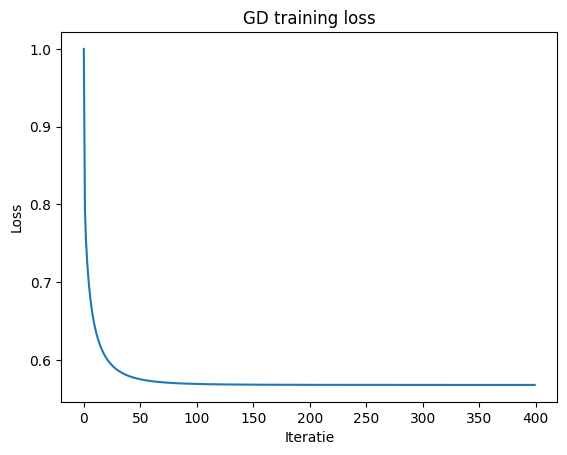

In [11]:
# Plot de loss-curve ter controle (vereist matplotlib)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses)
plt.title("GD training loss")
plt.xlabel("Iteratie")
plt.ylabel("Loss")
plt.show()


In [12]:
F_unit, fr_words = build_french_matrix(fr_emb, l2_normalize=True)
print(f"FR-matrix shape: {F_unit.shape}, aantal FR-woorden: {len(fr_words):,}")


FR-matrix shape: (5766, 300), aantal FR-woorden: 5,766


In [15]:
acc1 = evaluate_accuracy(test_pairs, R, en_emb, F_unit, fr_words, top_k=1)
acc5 = evaluate_accuracy(test_pairs, R, en_emb, F_unit, fr_words, top_k=5)
acc10 = evaluate_accuracy(test_pairs, R, en_emb, F_unit, fr_words, top_k=10)
acc15 = evaluate_accuracy(test_pairs, R, en_emb, F_unit, fr_words, top_k=15)

print(f"Top-1 accuracy: {acc1:.2%}")
print(f"Top-5 accuracy: {acc5:.2%}")
print(f"Top-10 accuracy: {acc10:.2%}")
print(f"Top-15 accuracy: {acc15:.2%}")



Evaluated on 1438 woorden — correct: 666 — Acc@1 = 46.31%
Evaluated on 1438 woorden — correct: 919 — Acc@5 = 63.91%
Evaluated on 1438 woorden — correct: 1007 — Acc@10 = 70.03%
Evaluated on 1438 woorden — correct: 1058 — Acc@15 = 73.57%
Top-1 accuracy: 46.31%
Top-5 accuracy: 63.91%
Top-10 accuracy: 70.03%
Top-15 accuracy: 73.57%


# Document Search op basis van Word Embeddings + LSH (Approximate KNN)

Doel: Gegeven een *querytekst* de *n* meest gelijkende zinnen (documenten) uit een corpus (bijv. Ilias/Odyssee) terugvinden.

Benadering:
1. **Cleaning & tokenization**: we normaliseren tekst zodat embeddings beter matchen.
2. **Documentvector**: som (of gemiddelde) van woord-embeddings van een zin → één vector per document.
3. **LSH (Locality Sensitive Hashing) met random hyperplanes**:
   - Projecteer vectors op *L* willekeurige hypervlakken.
   - Neem het teken (±) per projectie → *L*-bits handtekening → bucket-ID.
   - Alleen de *kandidaten* in dezelfde bucket als de query bekijken (≈ 1 bucket).
4. **k-NN met cosine similarity** *binnen* de gevonden bucket → top-*n* meest gelijkende zinnen.

Waarom LSH?
- Bespaart zoektijd: in plaats van *alle* documenten te vergelijken, beperken we ons tot één (kleine) bucket.
- Nadeel: door toeval kun je matches missen → daarom "Approximate" KNN.

Benodigd:
- Een embeddings-dictionary: `{woord -> np.ndarray(d,)}` (zelfde formaat als Deel I).
- Een lijst zinnen (`sentences`) uit je Ilias/Odyssee-voorbewerking.
- Een cleaning-functie uit eerdere opdrachten (hier leveren we een nette, generieke variant).


In [16]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Tuple, Sequence, Iterable, Optional
import numpy as np
import re


In [18]:
# NB: Pas deze cleaning zo nodig aan jouw eerdere opdracht (zelfde principes).
# Hier een solide, generieke variant: lowercasing, diacritics strippen (optioneel),
# cijfers/punctuatie eruit, whitespace normaliseren.

def simple_clean(text: str) -> str:
    """
    Eenvoudige normalisatie:
    - lowercase
    - verwijder niet-alfabetische karakters (bewust conservatief: a-z)
    - collapse spaties

    Let op:
    - Afhankelijk van je corpus kun je liever accenten behouden of lemma's gebruiken.
    - Hier kiezen we simpelheid, omdat de embeddings normaliter ook op plain tokens zijn getraind.
    """
    text = text.lower()
    # vervang alles dat geen a-z is door spatie
    text = re.sub(r"[^a-z]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def tokenize(text: str) -> List[str]:
    """
    Tokenizer na cleaning: split op spaties.
    """
    if not text:
        return []
    return text.split()


In [19]:
def sentence_to_vec(
    sentence: str,
    embeddings: Dict[str, np.ndarray],
    cleaner=simple_clean,
    agg: str = "sum",   # "sum" of "mean"
) -> Optional[np.ndarray]:
    """
    Zet een zin om naar één vector door embeddings van bekende tokens te aggregeren.
    - Standaard gebruiken we de SOM (zoals gevraagd), 'mean' is een optionele variant.
    - Tokens zonder embedding worden genegeerd.
    - Retourneert None als er geen enkel bekend token is.

    Waarom SOM?
    - Simpel, lineair en effectief: document = 'bag of vectors'.
    - 'Mean' is soms stabieler bij lengteverschillen; hier blijven we bij SOM zoals in de opdracht.
    """
    cleaned = cleaner(sentence)
    toks = tokenize(cleaned)
    vecs = [embeddings[t] for t in toks if t in embeddings]
    if not vecs:
        return None
    M = np.vstack(vecs).astype(np.float32)  # (n_tokens, d)
    if agg == "sum":
        v = M.sum(axis=0)
    elif agg == "mean":
        v = M.mean(axis=0)
    else:
        raise ValueError("agg moet 'sum' of 'mean' zijn.")
    return v.astype(np.float32)


def build_document_matrix(
    sentences: Sequence[str],
    embeddings: Dict[str, np.ndarray],
    cleaner=simple_clean,
    agg: str = "sum",
    l2_normalize: bool = True
) -> Tuple[np.ndarray, List[int]]:
    """
    Maakt een (N_used, d)-matrix met documentvectoren voor alle zinnen.
    - Zinnen zonder bekende tokens worden overgeslagen.
    - Houdt indexmapping bij: 'used_idx[i]' verwijst naar originele zin-index.

    l2_normalize=True:
    - We normaliseren elke documentvector naar lengte 1.
    - Hierdoor wordt cosine-similarity later een simpele dot-plot.
    """
    doc_vecs = []
    used_idx = []

    # Dimensie afleiden uit een voorbeeldembedding
    # (neemt aan dat embeddings niet leeg zijn)
    example = next(iter(embeddings.values()))
    d = example.shape[0]

    for i, s in enumerate(sentences):
        v = sentence_to_vec(s, embeddings, cleaner=cleaner, agg=agg)
        if v is None:
            continue
        doc_vecs.append(v.reshape(1, -1))
        used_idx.append(i)

    if not doc_vecs:
        raise ValueError("Geen enkele zin leverde een documentvector op (check cleaning/embeddings).")

    M = np.vstack(doc_vecs).astype(np.float32)  # (N_used, d)

    if l2_normalize:
        norms = np.linalg.norm(M, axis=1, keepdims=True)
        norms = np.maximum(norms, 1e-12)
        M = M / norms

    return M, used_idx


In [21]:
@dataclass
class LSHConfig:
    num_planes: int = 16   # aantal hypervlakken → lengte signature (16 bits = 65536 buckets)
    random_state: int = 42 # voor reproduceerbaarheid


class RandomHyperplaneLSH:
    """
    Locality Sensitive Hashing m.b.v. random hyperplanes:
    - Maak 'num_planes' willekeurige vectoren r_j in ℝ^d.
    - Voor elke documentvector x: bit_j = 1 als x·r_j >= 0 anders 0.
    - Bucket-ID = interpretatie van de bitstring als integer.
    - In deze opdracht zoeken we *één* bucket (exacte match op signatuur).
    """

    def __init__(self, d: int, cfg: LSHConfig = LSHConfig()):
        self.cfg = cfg
        rng = np.random.default_rng(cfg.random_state)
        # random hyperplanes: trek uit N(0,1); elke rij is één hypervlak
        self.R = rng.standard_normal(size=(cfg.num_planes, d)).astype(np.float32)

    def signature_bits(self, x: np.ndarray) -> np.ndarray:
        """
        Bepaal de bits (0/1) voor vector x t.o.v. alle hyperplanes.
        Aanname: x shape = (d,) of (1,d)
        """
        x = x.reshape(-1).astype(np.float32)
        # scores: (num_planes,)
        scores = self.R @ x
        bits = (scores >= 0.0).astype(np.uint8)
        return bits

    @staticmethod
    def bits_to_bucket(bits: np.ndarray) -> int:
        """
        Zet bits (0/1) om naar een integer bucket-ID (msb-first).
        """
        b = 0
        for bit in bits.tolist():
            b = (b << 1) | int(bit)
        return b


class LSHTable:
    """
    Eén LSH-table met random hyperplanes.
    - index(doc_matrix): maakt buckets: bucket_id -> list(doc_index)
    - query(q): geeft indices uit dezelfde bucket terug (of lege lijst)
    """

    def __init__(self, doc_matrix: np.ndarray, lsh: RandomHyperplaneLSH):
        """
        doc_matrix: (N, d) — idealiter L2-genormaliseerd
        """
        self.doc_matrix = doc_matrix
        self.lsh = lsh
        self.buckets = {}  # dict[int, list[int]]

    def index(self):
        """
        Stop alle documenten in buckets op basis van hun signatuur.
        """
        N, d = self.doc_matrix.shape
        self.buckets.clear()
        for i in range(N):
            x = self.doc_matrix[i]
            bits = self.lsh.signature_bits(x)
            bid = self.lsh.bits_to_bucket(bits)
            self.buckets.setdefault(bid, []).append(i)

    def query_bucket(self, q_vec: np.ndarray) -> List[int]:
        """
        Geef de lijst documentindices (rij-indexen in doc_matrix) terug
        die in *dezelfde* bucket zitten als q_vec. (Approximate KNN)
        """
        bits = self.lsh.signature_bits(q_vec)
        bid = self.lsh.bits_to_bucket(bits)
        return self.buckets.get(bid, [])


In [22]:
def cosine_topn_in_bucket(
    q_vec: np.ndarray,
    doc_matrix: np.ndarray,
    candidate_idx: Sequence[int],
    top_n: int = 5
) -> List[Tuple[int, float]]:
    """
    Cosine-ranking (dot-product) van query q_vec tegen alle kandidaten in 'candidate_idx'.
    Aanname: doc_matrix en q_vec zijn L2-genormaliseerd → cosine = dot.
    Retourneert lijst van (doc_row_index, score), gesorteerd aflopend.
    """
    if len(candidate_idx) == 0:
        return []

    # (1,d) dot (k,d)^T → (1,k)
    C = doc_matrix[np.asarray(candidate_idx)]
    q = q_vec.reshape(1, -1).astype(np.float32)
    scores = (q @ C.T).ravel()
    order = np.argsort(-scores)[:top_n]
    return [(int(candidate_idx[i]), float(scores[i])) for i in order]


def build_query_vec(
    query_text: str,
    embeddings: Dict[str, np.ndarray],
    cleaner=simple_clean,
    agg: str = "sum",
    l2_normalize: bool = True
) -> Optional[np.ndarray]:
    """
    Bouw de queryvector op precies dezelfde manier als documentvectoren.
    """
    q = sentence_to_vec(query_text, embeddings, cleaner=cleaner, agg=agg)
    if q is None:
        return None
    if l2_normalize:
        n = np.linalg.norm(q)
        if n < 1e-12:
            return None
        q = q / n
    return q.astype(np.float32)


In [23]:
@dataclass
class SearchIndex:
    sentences: List[str]           # originele zinnen
    used_idx: List[int]            # mapping: doc_matrix[i] hoort bij sentences[used_idx[i]]
    doc_matrix: np.ndarray         # (N_used, d), L2-genormaliseerd
    lsh_table: LSHTable
    embeddings_dim: int


def build_search_index(
    sentences: Sequence[str],
    embeddings: Dict[str, np.ndarray],
    cleaner=simple_clean,
    agg: str = "sum",
    num_planes: int = 16,
    random_state: int = 42,
) -> SearchIndex:
    """
    Bouwt:
    - Documentmatrix (L2-genormaliseerd)
    - LSH met 'num_planes' hyperplanes (bucket-onderverdeling)
    - LSH indexering van documenten
    Retourneert een SearchIndex die je kunt gebruiken om te zoeken.
    """
    doc_matrix, used_idx = build_document_matrix(
        sentences, embeddings, cleaner=cleaner, agg=agg, l2_normalize=True
    )
    d = doc_matrix.shape[1]
    lsh = RandomHyperplaneLSH(d, LSHConfig(num_planes=num_planes, random_state=random_state))
    table = LSHTable(doc_matrix, lsh)
    table.index()

    return SearchIndex(
        sentences=list(sentences),
        used_idx=used_idx,
        doc_matrix=doc_matrix,
        lsh_table=table,
        embeddings_dim=d
    )


def approximate_knn_search(
    index: SearchIndex,
    query_text: str,
    embeddings: Dict[str, np.ndarray],
    top_n: int = 5,
    cleaner=simple_clean,
    agg: str = "sum",
    fallback_fullscan: bool = True
) -> List[Tuple[str, float, int]]:
    """
    Voert de complete Approximate KNN uit:
    1) Query → queryvector (zelfde cleaning & aggregatie als corpus).
    2) LSH: haal kandidaten uit *dezelfde* bucket.
    3) Cosine-ranking binnen de bucket → top_n.
    4) Optionele fallback: als bucket leeg is, doe een *volle* scan (langzamer maar robuuster).

    Retourneert lijst: [(zin_tekst, score, originele_zin_index), ...]
    """
    q_vec = build_query_vec(query_text, embeddings, cleaner=cleaner, agg=agg, l2_normalize=True)
    if q_vec is None:
        return []

    cand = index.lsh_table.query_bucket(q_vec)

    if not cand and fallback_fullscan:
        # Fallback: geen kandidaten — doe full scan (exacte KNN) als safety-net.
        # => Dit breekt de "niet alle docs doorzoeken" eis *alleen* als de bucket leeg is.
        #    Je kunt fallback uitzetten als je strikt 1-bucket zoekt.
        cand = list(range(index.doc_matrix.shape[0]))

    top = cosine_topn_in_bucket(q_vec, index.doc_matrix, cand, top_n=top_n)

    results = []
    for row_i, score in top:
        orig_i = index.used_idx[row_i]
        results.append((index.sentences[orig_i], score, orig_i))
    return results
